# Reading In Data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#Read in data
Feb_hrl_lmps = pd.read_csv('Feb_hrl_lmps.csv')
Feb_auction = pd.read_csv('Feb_auction.csv')

#Convert column to datetimes
Feb_hrl_lmps['datetime_beginning_ept'] = pd.to_datetime(Feb_hrl_lmps['datetime_beginning_ept'])

#Convert to matrix format
Feb_hrl_lmps = Feb_hrl_lmps.pivot(index = 'datetime_beginning_ept', columns = 'pnode_id', values = 'congestion_price_da')

In [3]:
Feb_hrl_lmps.sample(3)

pnode_id,1,3,48592,48593,48594,48595,48596,48603,48604,48605,...,2156112519,2156112520,2156112521,2156112523,2156112524,2156112525,2156112528,2156112529,2156112530,2156112531
datetime_beginning_ept,,,,,,,,,,,,,,,,,,,,,
2022-02-27 03:00:00,1.333250,2.807756,-3.20,-3.20,-3.04,-3.04,-3.04,-3.07,-3.07,-3.67,...,-3.11,0.37,-2.84,-3.18,0.37,0.43,-0.52,0.45,13.03,-1.84
2022-02-21 00:00:00,2.130784,1.878977,-1.74,-1.74,-1.57,-1.57,-1.57,-1.60,-1.60,-2.04,...,-1.47,-1.30,-3.64,-1.72,-3.22,3.61,0.23,2.06,10.33,-0.74
2022-02-28 14:00:00,0.519860,0.733432,-0.49,-0.49,4.10,4.10,4.10,3.52,3.52,0.01,...,-1.10,-1.05,-1.32,-0.36,-0.55,-0.51,-0.07,-0.04,-0.05,-0.30


In [4]:
Feb_auction.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Purchase Month
17092,252962591,OnPeak,LFYETP,LEESVILL13 KV LE1,32418441,KERRDAM 14 KV G1,34887805,Sell,1.9,-6.11,2021-11-01
40948,255167792,OnPeak,APOETR,DELCOTAP13 KV DELCO,50524,CARDIFF 230 KV CARD SVC,31020665,Sell,1.5,6.68,2021-12-01
28701,253136353,OffPeak,MEAFT2,WILLIAMSPORT - AP,22515686,CALVERTC22 KV GEN 02,50661,Buy,0.8,-78.36,2021-11-01


## Getting Total Congestion LMP for relevant hours

In [5]:
import numpy as np

def lookup_lmp(df, lmps):
    
    class_type = df.index[0]
    
    if class_type == 'OnPeak':
        f = ((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    elif class_type == 'OffPeak':
        f = ~((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    else:
        f = lmps.index.weekday <= 7 #All days of week
        
    avg_lmp = lmps[f].sum().rename('congestion_price_da')
    
    df = df.merge(avg_lmp, left_on = 'Source PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Source clmp'})
    
    df = df.merge(avg_lmp, left_on = 'Sink PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Sink clmp'})
    
    return df

auc_results = Feb_auction.groupby('Class Type').apply(lookup_lmp, Feb_hrl_lmps)
auc_results.reset_index(drop=True, inplace = True)

In [6]:
auc_results.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Purchase Month,Source clmp,Sink clmp
12743,257657345,OffPeak,GEO2A,4 QUAD C18 KV QC-1,32417631,BISHOPHI34.5 KV BISHWF2,135389807,Buy,0.9,866.28,2022-01-01,-4470.44,-4618.09
151797,259300708,OnPeak,ELMGN,PANTHER 69 KV PANTR,50746,HARRISBU69 KV CT2,48934151,Sell,2.7,2132.34,2022-02-01,-281.63,2262.76
64436,254780663,OffPeak,SPRCPT,LIMERICK20 KV UNIT02,50543,DUNCANNON,32661123,Buy,0.3,-463.01,2021-12-01,-2459.91,-5937.14


# Analyzing the Premia for Each FTR

In [7]:
#Compute the Premium for each FTR
auc_results['Payoff'] = auc_results['Sink clmp'] - auc_results['Source clmp']
auc_results['Premium'] = auc_results['Payoff'] - auc_results['Obligation MCP']

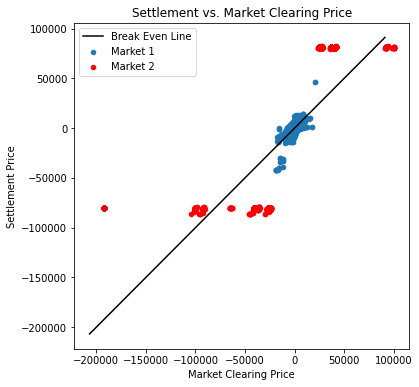

In [61]:
def plot_xy(ax, color='black'):
    l = min(ax.get_xlim()[0], ax.get_ylim()[0])
    r = min(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([l, r], [l, r], color = color, label = 'Break Even Line')
    
    
fig, ax = plt.subplots(1,1, figsize=(6,6))

buy_trades = auc_results['Trade Type'] == 'Buy'
outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers].plot.scatter('Obligation MCP', 'Payoff',ax=ax, label = 'Market 1')

auc_results[outliers].plot.scatter('Obligation MCP', 'Payoff',ax=ax, label='Market 2',color='red')
c=50000
ax.set_xlabel('Market Clearing Price')
ax.set_ylabel('Settlement Price')
plot_xy(ax)
ax.legend()
ax.set_title('Settlement vs. Market Clearing Price')
#fig.savefig('SPvsMCP.png',bbox_inches='tight')

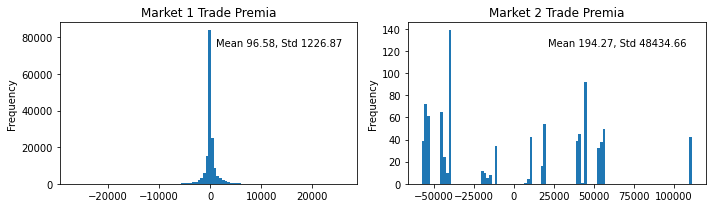

In [48]:
import numpy as np

def bool_to_pm1(xbool_):
    xpm1 = np.ones(xbool_.shape[0])
    xpm1[~xbool_] = -1
    return xpm1

#auc_results['Premium'] = auc_results['Cleared MW']*(auc_results['Payoff'] - auc_results['Obligation MCP'])*bool_to_pm1(buy_trades)

fig, ax = plt.subplots(1,2, figsize = (10,3), tight_layout = True)

f = ~outliers
auc_results[f]['Premium'].plot.hist(bins = 100, ax = ax[0])
ax[0].set_title('Market 1 Trade Premia')
ax[0].text(.9*ax[0].get_xlim()[1],.9*ax[0].get_ylim()[1],\
             'Mean {:.2f}, Std {:.2f}'.format(auc_results[f]['Premium'].mean(), auc_results[f]['Premium'].std()),\
            verticalalignment='top',horizontalalignment='right')

#f = sell_trades & outliers
f = outliers
auc_results[f]['Premium'].plot.hist(bins = 100, ax = ax[1])
ax[1].set_title('Market 2 Trade Premia')
ax[1].text(.9*ax[1].get_xlim()[1],.9*ax[1].get_ylim()[1],\
             'Mean {:.2f}, Std {:.2f}'.format(auc_results[f]['Premium'].mean(), auc_results[f]['Premium'].std()),\
            verticalalignment='top',horizontalalignment='right')


#fig.savefig('premia_hist.png',bbox_inches='tight')

In [10]:
#Making sure it's sorted by date
Feb_hrl_lmps.sort_index(inplace=True)

## Exploring how volatility affects premia

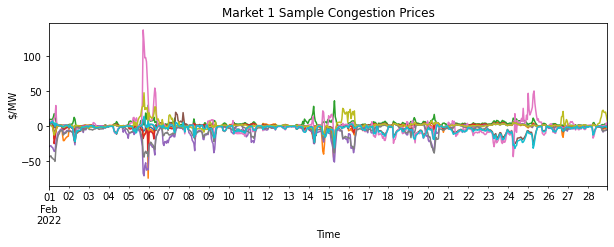

In [144]:
fig, ax = plt.subplots(1,1,figsize=(10,3))

for s in auc_results[~outliers]['Sink PNODEID'].sample(10):
    Feb_hrl_lmps.plot(y = s, ax=ax)

ax.set_title('Market 1 Sample Congestion Prices')
ax.set_ylabel('\$/MW')
ax.set_xlabel('Time')
ax.get_legend().remove()
#fig.savefig('m1congestion.png', bbox_inches = 'tight')

## Computing Vols

<AxesSubplot:>

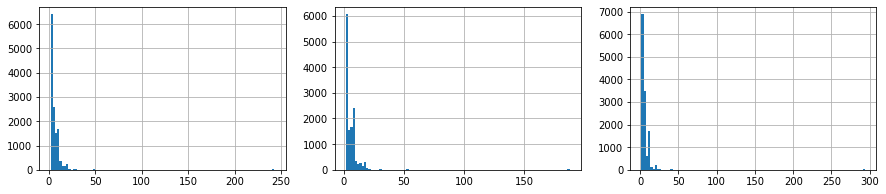

In [12]:
onpeak = ((Feb_hrl_lmps.index.weekday <= 5) &\
     (Feb_hrl_lmps.index.hour >= 7) &\
     (Feb_hrl_lmps.index.hour < 23))
offpeak = ~onpeak

fig, ax = plt.subplots(1, 3, figsize = (15,3))
Feb_hrl_lmps.std().hist(bins = 100, ax = ax[0])
Feb_hrl_lmps[onpeak].std().hist(bins = 100, ax = ax[1])
Feb_hrl_lmps[offpeak].std().hist(bins=100, ax = ax[2])

<AxesSubplot:xlabel='datetime_beginning_ept'>

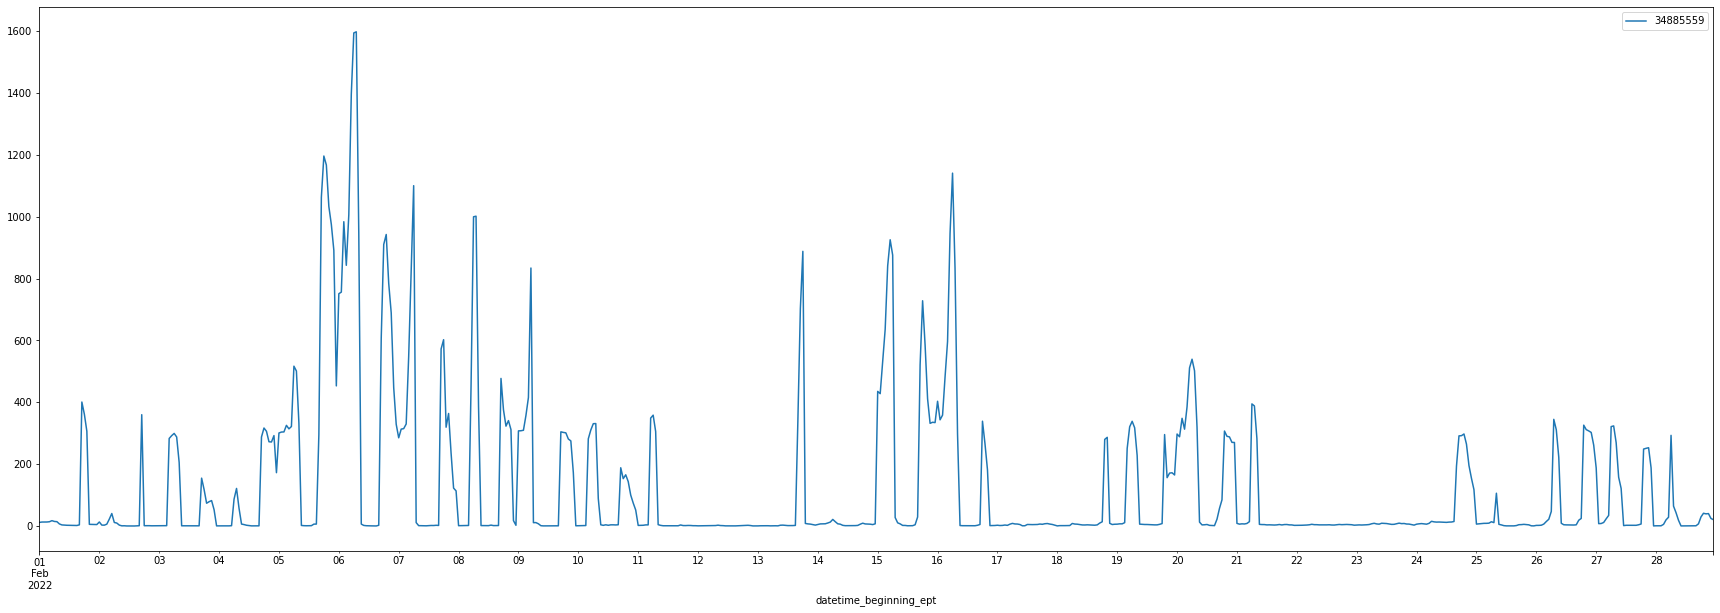

In [13]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
node_id = Feb_hrl_lmps.std().idxmax()
Feb_hrl_lmps.plot(y = node_id, ax = ax)

Text(0.5, 1.0, 'Market 1 Sample Autocorrelations')

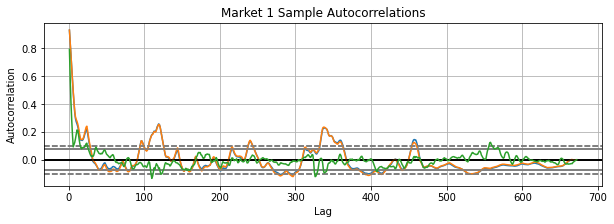

In [14]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(1,1,figsize=(10,3))

for s in auc_results[~outliers]['Source PNODEID'].sample(3):
    autocorrelation_plot(Feb_hrl_lmps[s], ax=ax)

ax.set_title('Market 1 Sample Autocorrelations')
#fig.savefig('m1autocorr.png',bbox_inches = 'tight')

In [15]:
def lookup_vol(df, lmps):    
    source = df['Source PNODEID'].iloc[0]
    sink = df['Sink PNODEID'].iloc[0]
    #return lmps[source].cov(lmps[sink])
    return (lmps[source]-lmps[sink]).std()
    
class_types = ['OffPeak', 'OnPeak', '24H']
split_auc = {}
lmp_filt = {}

for c in class_types:
    split_auc[c] = auc_results[auc_results['Class Type'] == c]
    if c == 'OnPeak':
        lmp_filt[c] = ((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    elif c == 'OffPeak':
        lmp_filt[c] = ~((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    else:
        lmp_filt[c] = Feb_hrl_lmps.index.weekday <= 7 #All days of week
        

for c in class_types:
    new = split_auc[c].groupby(by=['Source PNODEID', 'Sink PNODEID']).apply(lookup_vol, Feb_hrl_lmps[lmp_filt[c]])
    new.rename('new', inplace=True)
    split_auc[c] = split_auc[c].merge(right=new, left_on = ['Source PNODEID', 'Sink PNODEID'], right_index = True)
    split_auc[c].rename(columns={'new':'FTR Vol'}, inplace=True)
    del new
    
auc_results = pd.concat([split_auc[c] for c in class_types], ignore_index=True)

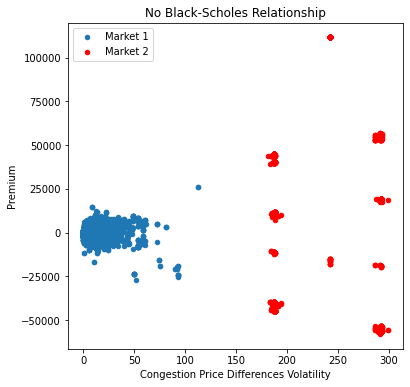

In [63]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

auc_results['FTR Percent Vol'] = auc_results['FTR Vol']/np.maximum(auc_results['Obligation MCP'].abs(),np.ones(auc_results.shape[0]))
outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers].plot.scatter(x='FTR Vol', y = 'Premium',ax=ax, label = 'Market 1')
auc_results[outliers].plot.scatter(x='FTR Vol', y = 'Premium',ax=ax,label = 'Market 2', color='red')
ax.set_xlabel('Congestion Price Differences Volatility')
ax.set_title('No Black-Scholes Relationship')
#fig.savefig('NoBS.png',bbox_inches='tight')

## Breaking down premium by month Purchased

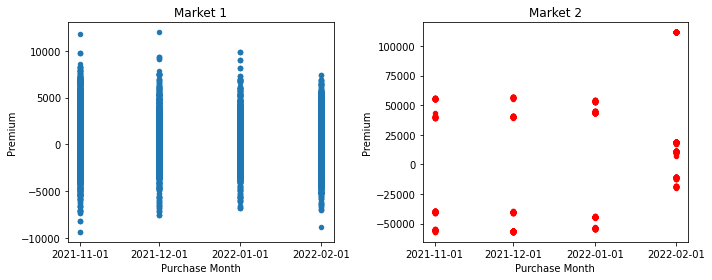

In [74]:
auc_results['Purchase Month'] = pd.to_datetime(auc_results['Purchase Month'])

fig, ax = plt.subplots(1,2,figsize=(10,4))
sell_trades = auc_results['Trade Type'] == 'Sell'

outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -50000)
auc_results[~outliers & sell_trades].plot.scatter(y = 'Premium', x = 'Purchase Month', ax = ax[0])
auc_results[outliers & sell_trades].plot.scatter(y = 'Premium', x = 'Purchase Month', ax = ax[1], color='red')

for i in [0,1]:
    ax[i].set_title('Market {:}'.format(i+1))
    ax[i].set_xticks([ax[i].get_xticks()[j] for j in [0,2,4,6]])
    
fig.tight_layout()
#fig.savefig('PremiaVsMonth.png',bbox_inches='tight')

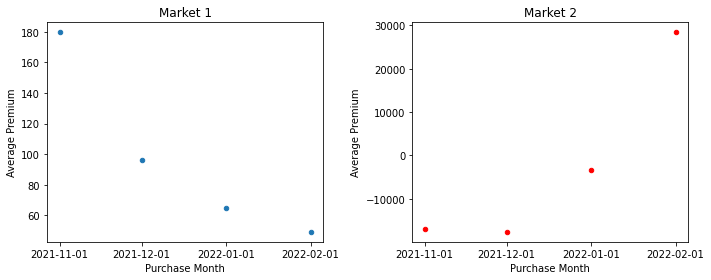

In [75]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

sell_trades = auc_results['Trade Type'] == 'Sell'
noout_mean = pd.DataFrame(auc_results[~outliers&sell_trades].groupby('Purchase Month').apply(lambda x : x['Premium'].mean()).rename('Premium')).reset_index()
noout_mean.plot.scatter(x='Purchase Month',y='Premium',ax=ax[0])

out_mean = pd.DataFrame(auc_results[outliers&sell_trades].groupby('Purchase Month').apply(lambda x : x['Premium'].mean()).rename('Premium')).reset_index()
out_mean.plot.scatter(x='Purchase Month',y='Premium',color='red',ax=ax[1])

for i in [0,1]:
    ax[i].set_title('Market {:}'.format(i+1))
    ax[i].set_ylabel('Average Premium')
    ax[i].set_xticks([ax[i].get_xticks()[j] for j in [0,2,4,6]])
    
fig.tight_layout()
#fig.savefig('AvgPremiaVsMonth.png',bbox_inches='tight')

# Look for Arbitrage (Price Disagreements)

In [113]:
#Makes a dictionary representation of a directed graph of edges
def make_graph(edges):
    g = {}
    for e in edges:
        if e[0] in g.keys():
            g[e[0]]['down'].append(e[1])
        else:
            g[e[0]] = {}
            g[e[0]]['down'] = [e[1]]
            g[e[0]]['up'] = []
            
        if e[1] in g.keys():
            g[e[1]]['up'].append(e[0])
        else:
            g[e[1]] = {}
            g[e[1]]['up'] = [e[0]]
            g[e[1]]['down'] = []
    
    return g

#Computes degree of a node in a directed graph
def get_degree(node):
    return len(node['up'])+len(node['down'])

#Enumerates all triangles in a directed graph
def enum_tri(graph):
    
    triangles = []
    
    for node in graph.keys():
        
        up_nbrs = graph[node]['up']
        down_nbrs = graph[node]['down']
        checked_nbrs = set({node})
        
        #i -> node
        for i in up_nbrs:
            i_up = graph[i]['up']
            i_down = graph[i]['down']
            checked_nbrs.add(i)
            
            #j -> i
            for j in i_up: #need to prune j from i neighbors for the purposes of counting at this node
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[j,node],[j,i]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[node,j],[j,i]]))
                    
            #i -> j
            for j in i_down:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[j,node],[i,j]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[i,node],[node,j],[i,j]])) 
                    
        #node -> i
        for i in down_nbrs:
            i_up = graph[i]['up']
            i_down = graph[i]['down']
            
            #j -> i
            for j in i_up:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[j,node],[j,i]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[node,j],[j,i]]))
                    
            #i -> j
            for j in i_down:
                #j -> node
                if j in up_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[j,node],[i,j]]))
                #node -> j
                elif j in down_nbrs and j not in checked_nbrs:
                    triangles.append(np.array([[node,i],[node,j],[i,j]]))
                    
        #Prune node from g
        graph[node]['up'] = []
        graph[node]['down'] = []
        for i in up_nbrs:
            try:
                graph[i]['down'].remove(node)
            except ValueError:
                print((i,node))
        for j in down_nbrs:
            graph[j]['up'].remove(node)
    return triangles

In [135]:
def count_tri(df):
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates()
    g = make_graph(edges.values)
    return len(enum_tri(g))

def sign(edge, ordered_nodes):
    if np.all(edge == [ordered_nodes[0],ordered_nodes[2]]):
        return -1
    elif np.all(edge == [ordered_nodes[2],ordered_nodes[0]]):
        return 1
    else:
        return np.sign(edge[1]-edge[0])

def arb(prices, triangle):
    arb_sum = 0
    mw = 1e10
    for edge in triangle:
        premium = prices[(edge[0],edge[1])][0]
        mw = min(mw, prices[(edge[0],edge[1])][1])
        arb_sum += premium*sign(edge, np.unique(triangle))
    return abs(arb_sum)*mw

def avg_arb(prices, triangle):
    arb_sum = 0
    for edge in triangle:
        premium = prices[(edge[0],edge[1])][0]
        arb_sum += premium*sign(edge, np.unique(triangle))
    return abs(arb_sum)

def Premium_ClearedMW(df):
    argmax = df['Premium'].argmax()
    return df['Premium'].iloc[argmax], df['Cleared MW'].iloc[argmax]

def total_arb(df):
    series = df.groupby(['Source PNODEID','Sink PNODEID']).apply(Premium_ClearedMW)
    prices_dict = series.to_dict()
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates().values
    triangles = enum_tri(make_graph(edges))
    return sum([arb(prices_dict, t) for t in triangles])

def count_tri(df):
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates().values
    triangles = enum_tri(make_graph(edges))
    return len(triangles)

def avg_arb_perMW(df):
    series = df.groupby(['Source PNODEID','Sink PNODEID']).apply(Premium_ClearedMW)
    prices_dict = series.to_dict()
    edges = df[['Source PNODEID','Sink PNODEID']].drop_duplicates().values
    triangles = enum_tri(make_graph(edges))
    return sum([avg_arb(prices_dict, t) for t in triangles])/len(triangles)

In [136]:
f = auc_results['Source PNODEID'] == auc_results['Sink PNODEID']
arb_summary = auc_results[~f].groupby(['Purchase Month','Class Type']).apply(total_arb)
arb_summary = pd.DataFrame(data=arb_summary.rename('Total Arbitrage, $',inplace = True))

arb_summary['No. of Triangles'] = auc_results[~f].groupby(['Purchase Month','Class Type']).apply(count_tri)
arb_summary['Avg. Arb Per Triangle, $/MW'] = auc_results[~f].groupby(['Purchase Month','Class Type']).apply(avg_arb_perMW)

In [137]:
arb_summary

Total Arbitrage, $  No. of Triangles  \
Purchase Month Class Type                                         
2021-11-01     24H               1.371632e-11                17   
               OffPeak           1.077600e+01             10686   
               OnPeak            8.884000e+00              8271   
2021-12-01     24H               4.800000e-01                 8   
               OffPeak           8.495000e+00              8534   
               OnPeak            1.051600e+01             13910   
2022-01-01     24H               4.547474e-12                 7   
               OffPeak           1.174100e+01             11467   
               OnPeak            9.729000e+00              9692   
2022-02-01     24H               3.110000e-01                50   
               OffPeak           2.767700e+01             17721   
               OnPeak            3.136000e+01             18337   

                           Avg. Arb Per Triangle, $/MW  
Purchase Month Class Type                               
2021-11-01     24H                        8.192140e-14  
               OffPeak                    2.081228e-03  
               OnPeak                     1.635836e-03  
2021-12-01     24H                        5.000000e-03  
               OffPeak                    1.863136e-03  
               OnPeak                     2.024443e-03  
2022-01-01     24H                        6.496391e-14  
               OffPeak                    2.125229e-03  
               OnPeak                     1.906727e-03  
2022-02-01     24H                        2.800000e-03  
               OffPeak                    2.068732e-03  
               OnPeak                     2.079402e-03

In [138]:
#arb_summary.to_latex(buf='arb.tex')